In [1]:
!pip install dicomsdl

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import dicomsdl as dicom


In [3]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
train.head()
train = train[[col for col in train.columns if col in ['site_id',
 'patient_id',
 'image_id',
 'laterality',
 'view',
 'age',
 'implant',
 'machine_id',
 'prediction_id','cancer']]]
test.drop(['prediction_id'],axis=1,inplace=True)
train.loc[train['age'].isnull(),'age'] = train['age'].mean()

#loading directory of images
path = os.path.join('/kaggle/input/rsna-breast-cancer-detection/train_images')
list_dir = os.listdir(path)
k =[]
y={}
mlo_path_l = []
cc_path_l = []
mlo_path_r = []
cc_path_r = []
for i, sub in tqdm.tqdm(enumerate(list_dir)):
    for j, fname in enumerate(os.listdir(os.path.join(path,sub))):
        view = (train.loc[train['image_id']==int(((fname).split('.'))[0]),'view'].values)[0]
        laterality = (train.loc[train['image_id']==int(((fname).split('.'))[0]),'laterality'].values)[0]
        cancer = int(train.loc[train['image_id']==int(((fname).split('.'))[0]),'cancer'])
        k.append(os.path.join(os.path.join(path,sub),fname))
        y[int(((fname).split('.'))[0])] = cancer
        if view =='MLO':
            if laterality=='L':
                 mlo_path_l.append(os.path.join(os.path.join(path,sub),fname))
            else:
                mlo_path_r.append(os.path.join(os.path.join(path,sub),fname))
        elif view =='CC':
            if laterality=='L':
                 cc_path_l.append(os.path.join(os.path.join(path,sub),fname))
            else:
                cc_path_r.append(os.path.join(os.path.join(path,sub),fname))
mlo_path_dict_l={}
for i in range(len(list(mlo_path_l))):
    mlo_path_dict_l[i] = mlo_path_l[i]


11913it [01:25, 139.20it/s]


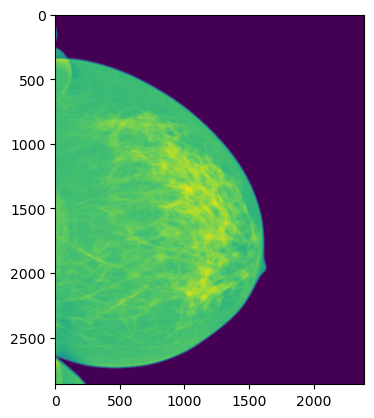

In [7]:
image = dicom.open('/kaggle/input/rsna-breast-cancer-detection/train_images/10042/102733848.dcm').pixelData(storedvalue=True)
plt.imshow(((((tf.cast(tf.expand_dims(image[100:-100,:2500],axis=-1),tf.float32)))/255.0)))

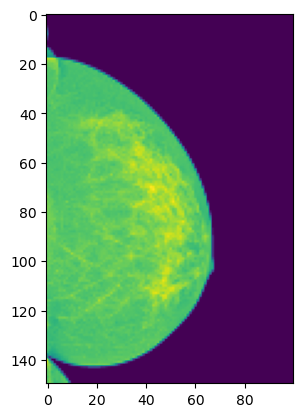

In [8]:
image = dicom.open('/kaggle/input/rsna-breast-cancer-detection/train_images/10042/102733848.dcm').pixelData(storedvalue=True)
plt.imshow(((tf.image.resize((tf.expand_dims(image[100:-100,:2500],axis=-1)),[150,100],preserve_aspect_ratio=False)))/255.)

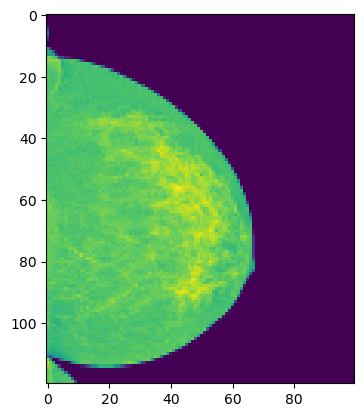

In [9]:
image = dicom.open('/kaggle/input/rsna-breast-cancer-detection/train_images/10042/102733848.dcm').pixelData(storedvalue=True)
plt.imshow(((tf.image.resize((tf.expand_dims(image[100:-100,:2500],axis=-1)),[150,100],preserve_aspect_ratio=True)))/255.)

In [10]:
(tf.image.resize(tf.expand_dims(image[100:-100,:2500],axis=-1),[150,100],preserve_aspect_ratio=True)/255.0)

<tf.Tensor: shape=(120, 100, 1), dtype=float32, numpy=
array([[[ 0.      ],
        [ 0.      ],
        [ 0.      ],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       [[ 0.      ],
        [ 0.      ],
        [ 0.      ],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       [[ 0.      ],
        [ 0.      ],
        [ 0.      ],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       ...,

       [[10.787481],
        [11.426299],
        [10.565022],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       [[11.034328],
        [11.374699],
        [10.668039],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]],

       [[10.764637],
        [11.509253],
        [10.826686],
        ...,
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]]], dtype=float32)>

In [11]:
tf.cast(image[-1,1000],dtype=tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

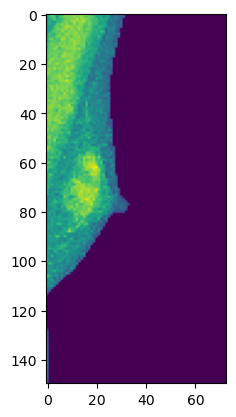

In [12]:
image = dicom.open('/kaggle/input/rsna-breast-cancer-detection/train_images/10086/1973073874.dcm').pixelData(storedvalue=True)
plt.imshow(2000- (tf.image.resize(tf.expand_dims(image[100:-100,:2500],axis=-1),[150,100],preserve_aspect_ratio=True))/255.0)

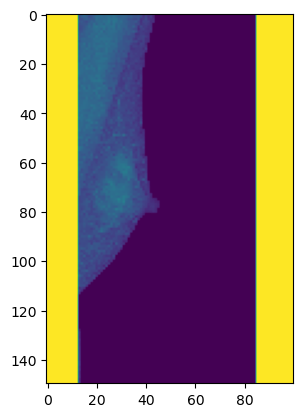

In [13]:
image = dicom.open('/kaggle/input/rsna-breast-cancer-detection/train_images/10086/1973073874.dcm').pixelData(storedvalue=True)
plt.imshow(2000/255- (tf.image.resize_with_pad(tf.expand_dims(image[100:-100,:2500],axis=-1),150,100))/255.0)

In [14]:
tf.config.run_functions_eagerly(True)
@tf.function
def gen(x):
    i = mlo_path_dict_l[x]
    image = (dicom.open(i).pixelData(storedvalue=True))
    max_val = tf.cast(image[-1,1000],dtype=tf.float32)
    #print(max_val)
    #if  train[train['image_id']==int(i.split('/')[-1].split('.')[0])]['laterality'].values[0]=='L':
    if max_val>=1000:
        return (max_val-tf.image.resize(tf.expand_dims(image[100:-100,:2500],axis=-1),[150,100],preserve_aspect_ratio=False))/255.0,(y[int(i.split('/')[-1].split('.')[0])])
    else:
        return (tf.image.resize(tf.expand_dims(image[100:-100,:2500],axis=-1),[150,100],preserve_aspect_ratio=False)/255.0),(y[int(i.split('/')[-1].split('.')[0])])
    #elif train[train['image_id']==int(i.split('/')[-1].split('.')[0])]['laterality'].values[0]=='R':
      #  if max_val>=1000:
      #      return ((max_val-tf.image.resize_with_pad(tf.image.flip_left_right(tf.expand_dims(image,axis=-1)),500,500))/255.0)[:,140:-60,0],(y[int(i.split('/')[-1].split('.')[0])])
      #  else:
       #     return (tf.image.resize_with_pad(tf.image.flip_left_right(tf.expand_dims(image,axis=-1)),500,500)/255.0)[:,140:-60,0],(y[int(i.split('/')[-1].split('.')[0])])



# Create a TensorFlow dataset and map your function to it
dataset= tf.data.Dataset.from_tensor_slices(np.arange((len(list(mlo_path_l)[:1600]))))
mlo_dataset = dataset.map(lambda x: tf.numpy_function(gen, inp=[x], Tout=(tf.float32,tf.int64))).batch(16)                

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [16]:
def pfbeta_fast(labels, predictions, beta=1):

    pTP = tf.math.reduce_sum(labels * predictions)
    pFP = tf.math.reduce_sum((1-labels) * predictions)
    num_positives = tf.math.reduce_sum((labels))  #  = pTP+pFN

    pPrecision = pTP/(pTP+pFP)
    pRecall = pTP/num_positives

    beta_squared = beta**2

    if (pPrecision > 0 and pRecall > 0):
        pF1 = (1+beta_squared) * pPrecision * pRecall/(beta_squared*pPrecision + pRecall)
        return pF1
    else:
        return 0.0


In [17]:


def mylayer(X,f,size,s,how='same',a=1):
    layer = tf.keras.layers.Conv2D(filters=f,kernel_size=size,strides=s,padding=how)(X)
    layer = tf.keras.layers.BatchNormalization()(layer)
    if a ==1:
        layer = tf.keras.layers.Activation('relu')(layer)
    else:
        layer +=0
    return layer
def add_layer(X_prev,X):
    added = tf.keras.layers.Add()([X_prev,X])
    return added
def conv_connect(X_prev,X,f,s,how='same'):
    layer = tf.keras.layers.Conv2D(filters=f,kernel_size=(1,1),strides=2,padding=how)(X_prev)
    layer = tf.keras.layers.ZeroPadding2D((7,7))(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = add_layer(layer,X)
    layer = tf.keras.layers.Activation('relu')(layer)
    return layer

def cnn():
    
    
    pre = tf.keras.applications.convnext.ConvNeXtSmall(
    model_name='convnext_small',
    include_top=False,
    include_preprocessing=True,
    weights='imagenet',
    input_shape=(150,100,3),pooling='avg')
    
    pre.trainable=True
    
    for layer in pre.layers[:-20]:
        layer.trainable=False
    inputs = tf.keras.Input(shape=(150,100,1))
    X = tf.keras.layers.Concatenate()([inputs for i in range(3)])
    X = pre(X)
    #X = tf.keras.layers.Dropout(0.20)(X)
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    model.summary()
    model.compile(loss='BinaryCrossentropy',optimizer = tf.keras.optimizers.Adam(),metrics=['accuracy',pfbeta_fast])
    return model



In [18]:
tf.keras.backend.clear_session()
model = cnn()
model.load_weights('/kaggle/input/naidu-cancer-comp/mlo_l_10e.h5')
#model.fit(mlo_dataset,verbose=True,epochs=7,callbacks=[tf.keras.callbacks.ModelCheckpoint('model.h5')])
 

198551472/198551472 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 150, 100, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 convnext_small (Functional

In [19]:
list_r=0
list_l=0
for i in os.listdir('/kaggle/input/rsna-breast-cancer-detection/test_images/10008'):
    image_id = int(i.split('.')[0])
    if test[test['image_id']==image_id]['laterality'].values[0] =='L':
        
        image = (dicom.open('/kaggle/input/rsna-breast-cancer-detection/test_images/10008/{}'.format((i))).pixelData(storedvalue=True))
        max_val = tf.cast(image[-1,1000],dtype=tf.float32)
        image = (tf.image.resize(tf.expand_dims(image[100:-100,:2500],axis=-1),[150,100],preserve_aspect_ratio=False))/255.0
        list_l +=model.predict(tf.expand_dims(image,0))[0,0]
    else:
        
        image = (dicom.open('/kaggle/input/rsna-breast-cancer-detection/test_images/10008/{}'.format((i))).pixelData(storedvalue=True))
        max_val = tf.cast(image[-1,1000],dtype=tf.float32)
        image = (tf.image.resize(tf.expand_dims(image[100:-100,:2500],axis=-1),[150,100],preserve_aspect_ratio=False))/255.0
        list_r +=model.predict(tf.expand_dims(image,0))[0,0]    


    

1/1 [==============================] - 1s 654ms/step


In [20]:
submission = pd.DataFrame({'prediction_id':['10008_L','10008_R'],'cancer':[list_l,list_r]})
submission.to_csv('submission.csv',index=False)
submission

,prediction_id,cancer
0,10008_L,0.000004
1,10008_R,0.000030
